# Basic Statistics for Cosmology: Exercises on $H_0$

This notebook is designed as a **student exercise**.  
You will work through **Frequentist** and **Bayesian** methods to estimate the Hubble constant $H_0$ from mock data.  

👉 This is the **exercise version** (without solutions).  
The instructor has a separate notebook with solutions.

---

## Instructions
- Fill in the code cells where you see `# TODO`.
- Answer the discussion questions in markdown cells.
- Try to first attempt on your own before checking solutions.

---

## Doing SN cosmology with a synthetic dataset, using luminosity distance relation

**Key low-$z$ relations** (valid for $z\lesssim0.1$):

$$ d_L \approx \frac{cz}{H_0} \quad (\text{in Mpc}) $$
$$ \mu \equiv m - M = 5\log_{10}\!\left( \frac{d_L}{\text{Mpc}} \right) + 25 $$
Combining these: 
$$ m = M + 5\log_{10}(cz) - 5\log_{10}(H_0) + 25. $$

If $M$ is known (from external calibration), one can directly infer $H_0$. If $M$ is unknown **and** you only fit SN data, then $(M, H_0)$ are nearly perfectly degenerate at low $z$—you must supply an $M$ prior or external constraint to break the degeneracy.



## Part 1: Frequentist Statistics

### Exercise 1.1: Load and Visualize Data
Generate a very simplistic SN dataset!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple

c_km_s = 299792.458  # speed of light in km/s

def mu_from_z(z, H0):
    """Low-z luminosity distance modulus: mu = 5 log10(c z / H0 [Mpc]) + 25.
    Here c is in km/s, H0 in km/s/Mpc, so cz/H0 is in Mpc.
    """
    dL_Mpc = (c_km_s * z) / H0
    return 5.0 * np.log10(dL_Mpc) + 25.0

def mag_model(z, H0, M):
    return M + mu_from_z(z, H0)

def sigma_mu_pec(z, v_pec=300.0, H0=70.0):
    """Approximate magnitude uncertainty from peculiar velocities.
    sigma_mu ~ (5/ln(10)) * (sigma_dL/dL).
    At low z, dL ~ cz/H0, so fractional distance error from peculiar velocity sigma_v is ~ sigma_v/(cz).
    """
    frac = v_pec/(c_km_s * z)
    return (5/np.log(10)) * frac

@dataclass
class SNSample:
    """
    Generate a synthetic supernova sample for cosmological parameter estimation.

    Parameters
    ----------
    z : np.ndarray
        Array of redshifts of the supernovae.
    m : np.ndarray
        Array of observed magnitudes of the supernovae.
    sigma_m : np.ndarray
        Array of total magnitude uncertainties (measurement + intrinsic + peculiar velocity).
    name : str
        Str for the name of the sample (default is "synthetic").
    """
    z: np.ndarray
    m: np.ndarray
    sigma_m: np.ndarray
    name: str = "synthetic"

def make_synthetic_sample(N=100, H0=73.0, M=-19.3, zmin=0.01, zmax=0.08,
                          sigma_meas=0.1, sigma_int=0.1, v_pec=300.0, rng=None) -> SNSample:
    """
    Generate a synthetic supernova sample for cosmological parameter estimation.

    Parameters
    ----------
    N : int
        Number of supernovae to simulate.
    H0 : float
        True Hubble constant (km/s/Mpc) used to generate the data.
    M : float
        True absolute magnitude of the supernovae.
    zmin : float
        Minimum redshift of the sample.
    zmax : float
        Maximum redshift of the sample.
    sigma_meas : float
        Measurement uncertainty in magnitudes (per SN).
    sigma_int : float
        Intrinsic scatter in magnitudes (per SN).
    v_pec : float
        RMS peculiar velocity in km/s (affects low-z distance errors).
    rng : int, np.random.Generator, or None
        Random seed or numpy random generator for reproducibility.

    Returns
    -------
    SNSample
        Dataclass containing arrays of redshift (z), observed magnitude (m), 
        total magnitude uncertainty (sigma_m), and sample name.
    """
    rng = np.random.default_rng(rng)
    z = np.sort(rng.uniform(zmin, zmax, size=N))
    mu = mu_from_z(z, H0)
    m_true = M + mu
    # per-SN error budget: measurement + peculiar velocity + intrinsic scatter
    sig_pec = sigma_mu_pec(z, v_pec=v_pec, H0=H0)
    sigma_tot = np.sqrt(sigma_meas**2 + sig_pec**2 + sigma_int**2)
    m_obs = rng.normal(m_true, sigma_tot)
    return SNSample(z=z, m=m_obs, sigma_m=sigma_tot, name="synthetic")

In [2]:
# TODO: generate and plot data with error bars
synthetic_sample = make_synthetic_sample(N=400)

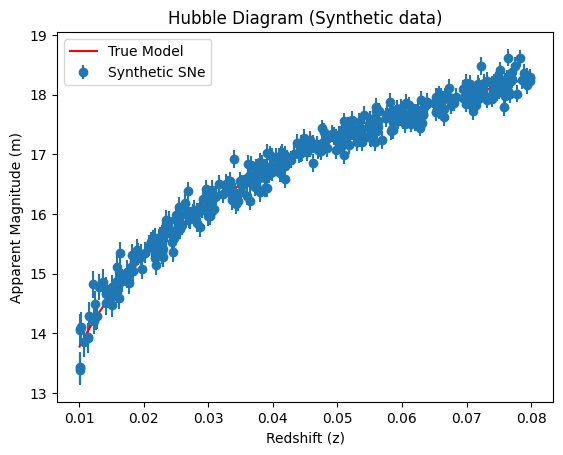

In [3]:
plt.errorbar(synthetic_sample.z, synthetic_sample.m, yerr=synthetic_sample.sigma_m, fmt='o', label='Synthetic SNe')
plt.plot(synthetic_sample.z, mag_model(z=synthetic_sample.z, H0=73.0, M=-19.3), color='r', label='True Model')
plt.xlabel('Redshift (z)')
plt.ylabel('Apparent Magnitude (m)')
plt.title("Hubble Diagram (Synthetic data)")
plt.legend()

### Exercise 1.2: Define the χ² function
Write down the chi-square function for the model.

In [4]:
# TODO: define chi2 function
def chi2(theta:list[float], x:np.array, y:np.array, sigma:np.array) -> float:
    # model = mag_model(z=x, H0=theta[0], M=theta[1])
    # return np.sum(((y-model)/sigma)**2)
    return sum([((yy - mag_model(z=xx, H0=theta[0], M=theta[1]))/ss)**2 for xx, yy, ss in zip(x, y, sigma)])

### Exercise 1.3: Minimize χ²
Find the best-fit parameters by minimizing χ².

In [5]:
# TODO: use numpy or scipy to minimize chi2
# best_fit of H0 = ...
from scipy.optimize import minimize as spmin

res = spmin(chi2, x0=np.array([70, -20]), args=(synthetic_sample.z, synthetic_sample.m, synthetic_sample.sigma_m))
res

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 393.62263184210366
        x: [ 7.009e+01 -1.938e+01]
      nit: 4
      jac: [ 2.289e-05  4.578e-05]
 hess_inv: [[ 2.804e-02  8.768e-04]
            [ 8.768e-04  5.677e-05]]
     nfev: 124
     njev: 38

Text(0, 0.5, '$\\chi^2(H_0)$')

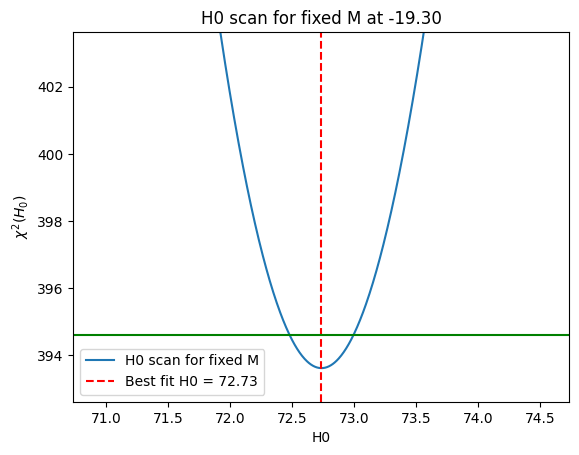

In [6]:
H0_grid = np.linspace(50, 90, 10000)
M_grid = np.linspace(-21, -18, 10000)

# for now fix M
fixedM = -19.3
# chi2_grid_fixedM = np.array([chi2([H0, fixedM], synthetic_sample.z, synthetic_sample.m, synthetic_sample.sigma_m) for H0 in H0_grid])
chi2_grid_fixedM = chi2([H0_grid, fixedM], synthetic_sample.z, synthetic_sample.m, synthetic_sample.sigma_m)
best_chi2 = chi2_grid_fixedM.min()
best_H0 = H0_grid[chi2_grid_fixedM.argmin()]

plt.plot(H0_grid, chi2_grid_fixedM, label="H0 scan for fixed M")
plt.axvline(x=best_H0, ls='--', color='red', label=f"Best fit H0 = {best_H0:.2f}")
plt.axhline(y=best_chi2+1, color="green")
plt.ylim(best_chi2-1, best_chi2+10)
plt.xlim(best_H0-2, best_H0+2)
plt.legend()
plt.title(f"H0 scan for fixed M at {fixedM:.2f}")
plt.xlabel("H0")
plt.ylabel(r"$\chi^2(H_0)$")

In [7]:
# TODO: say something about goodness of fit
chi2_grid_fixedM.min()/len(synthetic_sample.z)

np.float64(0.984056608385172)

Text(0, 0.5, 'Residual magnitude')

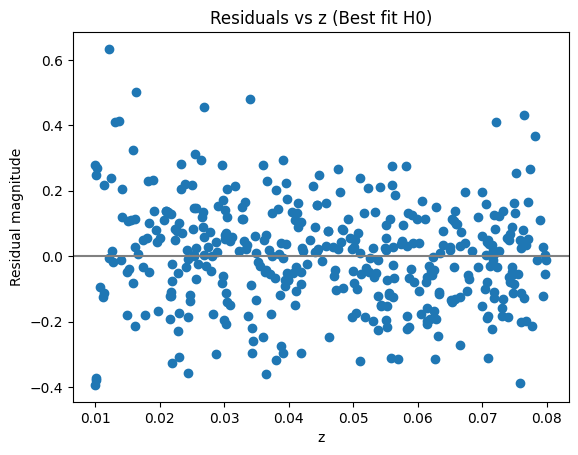

In [8]:
# TODO: plot residuals, always!
residuals_grid = synthetic_sample.m-mag_model(synthetic_sample.z,best_H0,fixedM)
plt.scatter(synthetic_sample.z,residuals_grid)
plt.axhline(0, color='gray')
plt.title("Residuals vs z (Best fit H0)")
plt.xlabel("z")
plt.ylabel("Residual magnitude")

### Exercise 1.4: Bootstrap uncertainties
Use bootstrap resampling to estimate parameter uncertainties.

Bootstrap median H0 = 72.75 km/s/Mpc
Bootstrap 68% interval: [72.45, 73.00] km/s/Mpc


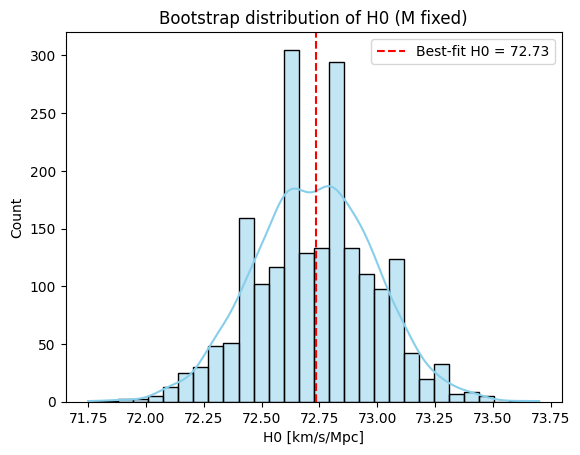

In [9]:
# TODO: implement bootstrap loop, any ideas how to do this?

# The concept is to resample the data with replacement, fit each resampled dataset, and collect the best-fit parameters to estimate uncertainties.

def best_fit_H0_given_M(sn: SNSample, M, H0_grid=np.linspace(50, 90, 801)):
    chi2_vals = chi2([H0_grid, M], sn.z, sn.m, sn.sigma_m)
    j = np.argmin(chi2_vals)
    return H0_grid[j], chi2_vals, H0_grid

def bootstrap_H0(sn: SNSample, M, nboot=500, rng=None):
    """
    Estimate the uncertainty in H0 by bootstrapping the SN sample.

    Parameters
    ----------
    sn : SNSample
        The supernova sample (with z, m, sigma_m arrays).
    M : float
        The assumed absolute magnitude of the supernovae.
    nboot : int, optional
        Number of bootstrap resamples (default: 500).
    rng : np.random.Generator or None, optional
        Random number generator or seed (default: None).

    Returns
    -------
    np.ndarray
        Array of best-fit H0 values from each bootstrap resample.
    """
    rng = np.random.default_rng(rng)
    H0s = []
    idx = np.arange(len(sn.z))
    H0_grid = np.linspace(50, 90, 801) # same grid as before
    for _ in range(nboot):
        # Resample SN indices with replacement
        sel = rng.choice(idx, size=len(idx), replace=True)
        # Create a new SNSample with the resampled data
        sn_b = SNSample(sn.z[sel], sn.m[sel], sn.sigma_m[sel], name=sn.name)
        # Find best-fit H0 for this resample
        hbest, chi2_vals, Hg = best_fit_H0_given_M(sn_b, M, H0_grid=H0_grid)
        H0s.append(hbest)
    return np.array(H0s)

import seaborn as sns

H0_boot = bootstrap_H0(synthetic_sample, fixedM, nboot=2000, rng=42)
h_med = np.median(H0_boot)
h_lo, h_hi = np.percentile(H0_boot, [16, 84])
print(f"Bootstrap median H0 = {h_med:.2f} km/s/Mpc")
print(f"Bootstrap 68% interval: [{h_lo:.2f}, {h_hi:.2f}] km/s/Mpc")

plt.figure()
sns.histplot(H0_boot, bins=30, kde=True, stat="count", color="skyblue", edgecolor="k")
plt.axvline(best_H0, color='r', linestyle='--', label=f'Best-fit H0 = {best_H0:.2f}')
plt.xlabel('H0 [km/s/Mpc]')
plt.ylabel('Count')
plt.title('Bootstrap distribution of H0 (M fixed)')
plt.legend()
plt.show()


### Exercise 1.5: p-value
Calculate a p-value from the sampled probability

In [10]:
# TODO: let's calculate a p-value from the sampled probability


### Exercise 1.6: Compare with MLE
Explain how minimizing χ² relates to Maximum Likelihood Estimation.

👉 *Write your discussion here*

With $\chi^2$ defined as $-2*\log{\mathcal{L}}$, Maximum Likelihood Estimation is equivalent to $\chi^2$ minimization.

In [11]:
H0_grid = np.linspace(best_H0-6, best_H0+6, 200)
M_grid  = np.linspace(fixedM-0.3, fixedM+0.3, 200)

H0_M_grid = np.meshgrid(H0_grid, M_grid)
H0_tab, M_tab = H0_M_grid
H0_tab = H0_tab.ravel()
M_tab = M_tab.ravel()

def loglikelihood(H0, M, x, y, sigma, Mcal=-19.3, sigma_Mcal=0.05):
    return chi2([H0, M], x, y, sigma) + (M - Mcal)**2/sigma_Mcal**2

loglikelihood_tab = loglikelihood(H0_tab, M_tab, synthetic_sample.z, synthetic_sample.m, synthetic_sample.sigma_m, Mcal=-19.3, sigma_Mcal=0.05)

best_H0_MLE, best_M_MLE = H0_tab[bestidx:=loglikelihood_tab.argmin()], M_tab[bestidx]
best_likelihood = loglikelihood_tab[bestidx]

print(best_H0_MLE, best_M_MLE)

72.70412267357389 -19.301507537688444


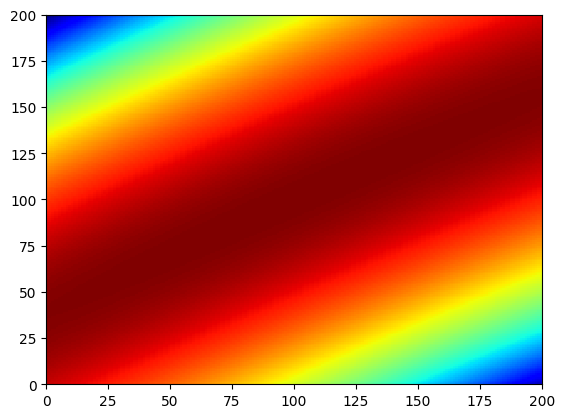

In [12]:
plt.pcolormesh(loglikelihood_tab.reshape((200, 200)), cmap="jet_r", vmin=loglikelihood_tab.min(), vmax=loglikelihood_tab.max())

## Part 2: Bayesian Statistics

### Exercise 2.1: Bayes' theorem
Write Bayes' theorem and identify prior, likelihood, posterior.

👉 *Write Bayes' theorem in your own words here*

### Exercise 2.2: Compute Posterior on a Grid
Define priors and likelihood, then compute posterior on a parameter grid.

In [13]:
H0_grid = np.linspace(best_H0-6, best_H0+6, 200)
M_grid  = np.linspace(fixedM-0.3, fixedM+0.3, 200)

H0_M_grid = np.meshgrid(H0_grid, M_grid)
H0_tab, M_tab = H0_M_grid
H0_tab = H0_tab.ravel()
M_tab = M_tab.ravel()

def gaussian_logprior_M(M, Mcal=-19.3, sigma_Mcal=0.05):
    return ((M-Mcal)/sigma_Mcal)**2

def uniform_prior_H0(H0):
    return (H0 > 0.).astype(float)

def logposterior(M, H0, x, y, sigma):
    return chi2([H0, M], x, y, sigma) + np.log(uniform_prior_H0(H0)) + gaussian_logprior_M(M)

In [14]:
logposterior_tab = logposterior(M_tab, H0_tab, synthetic_sample.z, synthetic_sample.m, synthetic_sample.sigma_m)

### Exercise 2.3: Normalize Posterior and Extract Marginal Estimates
Normalize posterior, compute marginal estimations of $H_0$ and $M$

In [51]:
# TODO: normalize posterior
# TODO: compute marginal distributions
logposterior_tab_norm = (logposterior_tab - logposterior_tab.min())
posterior_tab_norm = np.exp(-1/2*logposterior_tab_norm.reshape((200, 200)))
posterior_tab_norm = posterior_tab_norm / (posterior_tab_norm.sum())

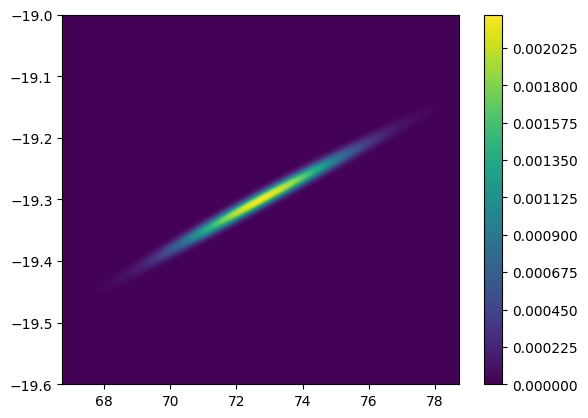

In [52]:
# plt.pcolormesh(posterior_tab_norm, cmap="jet") #, vmin=posterior_tab_norm.min(), vmax=posterior_tab_norm.max())
plt.contourf(H0_grid, M_grid, posterior_tab_norm.reshape(200, 200), 100)
plt.colorbar()

### Exercise 2.4: Credible Interval
Compute the 68% credible interval from the posterior.

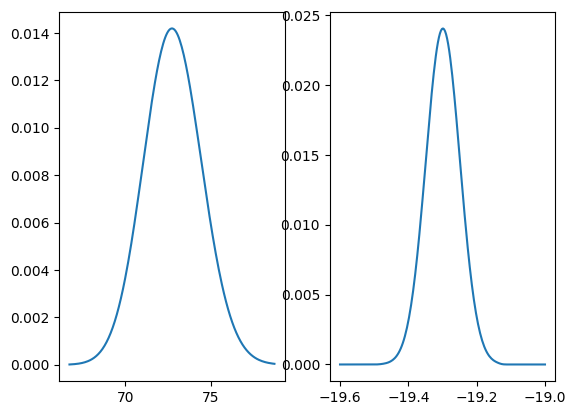

In [53]:
# TODO: credible interval calculation
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(H0_grid, np.sum(posterior_tab_norm.reshape(200, 200), axis=0))
ax2.plot(M_grid, np.sum(posterior_tab_norm.reshape(200, 200), axis=1))

### Exercise 2.5: Compare with Frequentist Result
Compare Bayesian and Frequentist estimates of $H_0$.

In [54]:
best_H0_Bay, best_M_Bay = H0_tab[bestidx:=logposterior_tab_norm.argmin()], M_tab[bestidx]
best_posterior = logposterior_tab_norm[bestidx]

print(best_H0_Bay, best_M_Bay)

72.70412267357389 -19.301507537688444


👉 *Write your comparison here*

## Part 3: Re-do with `Cobaya`

Estimate $H_0$ using Cobaya and Bayesian Statistics and compare

In [23]:
def coblikelihood(H0, M):
    return -0.5 * chi2([H0, M], synthetic_sample.z, synthetic_sample.m, synthetic_sample.sigma_m)

In [24]:
# Fill the configuration dictionary called 'info' below

info_dict = {
    'params': {
        'H0': {'prior': {'min': 50, 'max': 90}, 'latex': r'H_0'},
        'M':  {"prior": {"dist": "norm", "loc": -19.3, "scale": 0.05}, 'latex': r'M'},
    },
    'likelihood': {
        'my_sn_likelihood': {
            'external': coblikelihood,        }
    },
    'sampler': {'mcmc': {'max_tries': 100000, 'Rminus1_stop': 0.001}}}

In [25]:
from cobaya.run import run

updated_info, sampler = run(info_dict)

[my_sn_likelihood] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[prior] Reference values or pdfs for some parameters were not provided. Sampling from the prior instead for those parameters.
[mcmc] Initial point: H0:58.55929, M:-19.29404
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {my_sn_likelihood: 634.0}
[prior] *WARNING* Reference pdf not defined or improper for some parameters. Using prior's sigma instead for them.
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2025-08-28 16:44:12 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 0.039
[mcmc]  - Convergence of means: R-1 = 1.292181 after 64 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence

[root] *WARNING* outlier fraction 0.00013736263736263736 
Mean:
[ 72.82330689 -19.29801176]
Covariance matrix:
[[2.87516255e+00 8.38024129e-02]
 [8.38024129e-02 2.50200741e-03]]


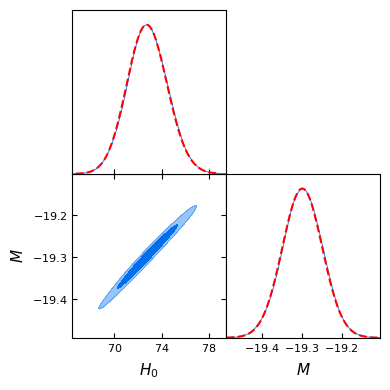

In [74]:
# Import corresponding modules from GetDist
from getdist.mcsamples import loadMCSamples, MCSamplesFromCobaya
import getdist.plots as gdplt

# Load the chains and the updated config file from the previous run
gd_sample = MCSamplesFromCobaya(updated_info, sampler.products()["sample"])

# Analyze the chains (print the mean and covmat according to GetDist documentation)
mean = gd_sample.getMeans([0, 1])
covmat = gd_sample.getCov(2)
print("Mean:")
print(mean)
print("Covariance matrix:")
print(covmat)

# PLOT THE CHAINS (have a look at the DEMO above from GetDist)
# The goal is to produce a triangle plot 

g = gdplt.get_subplot_plotter()
g.triangle_plot([gd_sample], ["H0", "M"], filled=True)

dM = (M_grid[1]-M_grid[0])
dH0 = (H0_grid[1]-H0_grid[0])

g.fig.axes[1].plot(H0_grid, np.sum(posterior_tab_norm.reshape(200, 200), axis=0)  / np.sum(posterior_tab_norm.reshape(200, 200), axis=0).max(), color='red', ls='--')
g.fig.axes[2].plot(M_grid, np.sum(posterior_tab_norm.reshape(200, 200), axis=1) / np.sum(posterior_tab_norm.reshape(200, 200), axis=1).max(), color='red', ls='--')